# RNN - Encoder-Decoder Model

## Toy-Project: Simple Calculator using RNN

- input:

        '1','5','5', '+', '3','3','9'


- output:

        '4', '9', '3', ' ', ' '
  

- 입력은 숫자 두 개에 대한 연산식

- 출력은 연산 결과 문자열

- 입력 숫자는 각각 1~3 자리로서, 전체 수식은 연산자 포함해서 최대 7자

- 출력 숫자는 1~4 자리인데, END 표시로 사용하는 `' '` 문자 포함해서 최대 5자



## RNN, Encoder/Decoder

<img  src="20160120182108205.jpg" style="width:55.0rem"/>

<div style="text-align:center">이미지 출처: http://www.voidcn.com/article/p-virvaiso-zw.html</div>


<img src="68747.jpg" style="width:55.0rem">

<div style="text-align:center">이미지 출처: https://github.com/guillaume-chevalier/seq2seq-signal-prediction</div>


### Encoder/Decoder - Inference

- 수식이 encoder 쪽에 들어오면, encoder 는 _**계산**_ 을 해서 그 결과를 state 로 기억
- decoder 쪽에 START 문자 (`'='`) 가 입력되고 decoder 가 시작되면, encoder 의 state 를 받아 초기 상태로 사용하면서 state 가 표현하려는 결과를 다시 숫자열로 출력

### Encoder/Decoder - Training

- 입력할 수식, 출력할 숫자열을 훈련데이터로 제시
- 출력할 숫자열은 sequence-to-sequence 방식으로 훈련
  - decoder 입력으로는 `'='` 문자를 앞에 붙인 출력 숫자열 제시
  - decoder 출력으로는 `' '` 문자 (END) 를 뒤에 붙인 수식을 제시
  - decoder 입력-출력 pair 를 하나씩 보면, 앞 자리의 숫자를 입력하면 현재 자리의 숫자를 출력하는 RNN을 학습하는 것이 됨
  
  
```
                                                 decoder outputs

                                                5   7   9   
        +---+---+---+---+---+---+---+         +---+---+---+---+
encoder |   |   |   |   |   |   |   +---------+   |   |   |   | decoder
        +---+---+---+---+---+---+---+         +---+---+---+---+

          1   2   3   +   4   5   6             =   5   7   9

              encoder inputs                     decoder inputs
```

## Let's Go

In [1]:
!rm -fr logdir2
!mkdir -p logdir2

In [2]:
%load_ext do_not_print_href
%matplotlib inline
from __future__ import print_function, division
import sys
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Prepare data set - symbols & symbol map

- 입력/출력 문자는 0~9 까지의 숫자, 연산자 `'+'`, `' '` (END), `'='` (START) 포함하여 13 종류

- 사용가능한 연산자는 `'+'`

- 문자(symbol) 와 해당 문자의 인덱스 넘버 사이의 변환을 위한 배열/사전 준비

  - `symbols[]`    : 인덱스에서 문자로
  - `symbol_map[]` : 문자에서 인덱스로


In [3]:
symbols        = [' ', '0', '1', '2', '3', '4', '5',
                  '6', '7', '8', '9', '+', '=']
operators      = ['+']

symbol_map     = {s: i \
                  for i,s in enumerate(symbols)}
input_units    = output_units    = len(symbol_map)
hidden_units   = 100

In [4]:
print('symbol_map =',symbol_map)

symbol_map = {' ': 0, '+': 11, '1': 2, '0': 1, '3': 4, '2': 3, '5': 6, '4': 5, '7': 8, '6': 7, '9': 10, '8': 9, '=': 12}


## Prepare data set - Preview

In [5]:
def make_random_data():
    t1        = str(np.random.randint(1000))
    op        = np.random.choice(operators)
    t2        = str(np.random.randint(1000))
    
    expr      = t1 + op + t2
    ans       = '='+str(eval(expr))+' '
    
    return expr, ans

In [6]:
for i in range(5):
    expr, ans = make_random_data()
    print(([c for c in expr], [c for c in ans]))

(['6', '+', '7', '3', '4'], ['=', '7', '4', '0', ' '])
(['5', '0', '6', '+', '7', '4', '3'], ['=', '1', '2', '4', '9', ' '])
(['5', '8', '0', '+', '5', '7', '4'], ['=', '1', '1', '5', '4', ' '])
(['7', '9', '1', '+', '3', '7', '3'], ['=', '1', '1', '6', '4', ' '])
(['9', '4', '1', '+', '3', '4', '3'], ['=', '1', '2', '8', '4', ' '])


## Prepare data set - one-hot encoding

In [7]:
def one_hot(n):
    """
    3 ==> [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    """
    res = np.zeros(13, dtype=np.float32)
    res[n] = 1.0
    return res

def arg_max(v):
    """
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0] ==> 3
    """
    return np.argmax(v, axis=-1)

# test
assert 7 == arg_max(one_hot(7))

In [8]:
encoder_max_seq_len = 7
decoder_max_seq_len = 5

In [9]:
def str_to_onehot(str, max_seq_len):
    buf           = np.zeros([max_seq_len,input_units])
    buf          += \
      one_hot(symbol_map[' ']).reshape([1,-1]) # <<<===
    seq_len       = len(str)
    buf[:seq_len] = [one_hot(symbol_map[c]) for c in str]
    return buf

In [10]:
def onehot_to_str(data, data_len):
    return ''.join([symbols[v] \
                    for v in arg_max(data)][:data_len])

In [11]:
def encode_data(expr, ans):
    e_seq_len         = len(expr)
    e_in              = str_to_onehot(expr,
                                      encoder_max_seq_len)
    d_seq_len         = len(ans) - 1
    d_in              = str_to_onehot(ans[:-1],
                                      decoder_max_seq_len)
    d_out             = str_to_onehot(ans[1:],
                                      decoder_max_seq_len)
    return e_seq_len, e_in, d_seq_len, d_in, d_out

In [12]:
def decode_data(e_len, e_in, d_len, d_in, d_out):
    return  e_len, \
            onehot_to_str(e_in, e_len), \
            d_len, \
            onehot_to_str(d_in, d_len), \
            onehot_to_str(d_out, d_len)

In [13]:
decode_data(*encode_data(*make_random_data()))

(7, '399+997', 5, '=1396', '1396 ')

## Prepare data set: create data set

In [14]:
BATCH_SIZE = 200

In [15]:
train_num_data = 60000
test_num_data  = 10000

In [16]:
# common data format
# e_len, e_in, d_len, d_in, d_out

class Dataset:
    def __init__(self):
        self.encoder_seq_len  = []
        self.encoder_in_data  = []
        self.decoder_seq_len  = []
        self.decoder_in_data  = []
        self.decoder_out_data = []
        
    def append(self, t):
        self.encoder_seq_len.append(t[0])
        self.encoder_in_data.append(t[1])
        self.decoder_seq_len.append(t[2])
        self.decoder_in_data.append(t[3])
        self.decoder_out_data.append(t[4])
        
    def next_batch(self,batch_size=BATCH_SIZE):
        data_len = len(self.encoder_seq_len)
        batch_pointer = 0
        while batch_pointer + batch_size <= data_len:
            ss   = np.random.randint(
                data_len - batch_size - 1)
            yield \
                self.encoder_seq_len[ss:ss+batch_size], \
                self.encoder_in_data[ss:ss+batch_size], \
                self.decoder_seq_len[ss:ss+batch_size], \
                self.decoder_in_data[ss:ss+batch_size], \
                self.decoder_out_data[ss:ss+batch_size]
            batch_pointer += batch_size


np.random.seed(37L)

train_data = Dataset()
for i in range(train_num_data):
    expr, ans     = make_random_data()
    train_data.append(encode_data(expr, ans))

test_data  = Dataset()
for i in range(test_num_data):
    expr, ans     = make_random_data()
    test_data.append(encode_data(expr, ans))

## Prepare data set: data structure

### print & verify first training data

- `next_batch()` 는 `for` 문장과 함께 쓰일 수 있음.
- `next_batch()` 가 `for` 문장과 함께 쓰지지 않는 경우는 다시 next() 를 호출해야 함. (python interator)

In [17]:
e_len,e_in,d_len,d_in,d_out = train_data.next_batch().next()
decode_data(e_len[0],e_in[0],d_len[0],d_in[0],d_out[0])

(6, '756+55', 4, '=811', '811 ')

In [18]:
decode_data(e_len[1],e_in[1],d_len[1],d_in[1],d_out[1])

(7, '269+927', 5, '=1196', '1196 ')

## Tensorflow - build graph

In [19]:
tf.reset_default_graph()

## Tensorflow - placeholders & dynamic batch_size

In [20]:
encoder_inputs   = tf.placeholder(
    dtype=tf.float32,
    shape=[None, encoder_max_seq_len, input_units],
    name='encoder_inputs')
encoder_seqlen   = tf.placeholder(
    dtype=tf.int32,
    shape=[None],
    name='encoder_seqlen')
decoder_inputs   = tf.placeholder(
    dtype=tf.float32,
    shape=[None, decoder_max_seq_len, input_units],
    name='decoder_inputs')
decoder_targets  = tf.placeholder(
    dtype=tf.float32,
    shape=[None, decoder_max_seq_len, output_units],
    name='decoder_targets')
decoder_seqlen   = tf.placeholder(
    dtype=tf.int32,
    shape=[None],
    name='decoder_seqlen')
encoder_training = tf.placeholder(
    dtype=tf.bool,
    shape=None,
    name='encoder_training')
tf_batch_size = tf.shape(encoder_inputs)[0] # <<== !!!

In [21]:
tf_batch_size

<tf.Tensor 'strided_slice:0' shape=() dtype=int32>

## RNN, Encoder/Decoder - 2-Layers, with Dropouts

- [`tf.cond()`](http://devdocs.io/tensorflow~python/tf/cond)
> Return true_fn() if the predicate pred is true else false_fn()

```
cond(
    pred,
    true_fn=None,
    false_fn=None,
    strict=False,
    name=None,
    fn1=None,
    fn2=None
)
```

- `true_fn`, `false_fn` 에는 [lambda expression](https://docs.python.org/2.7/reference/expressions.html#lambda) 이 종종 사용됨



In [22]:
dropout_rate = 0.2
keep_prob = tf.cond(encoder_training,
                    lambda: tf.constant(1.0-dropout_rate),
                    lambda: tf.constant(1.0),
                    name='keep_prob')

### [`tf.contrib.rnn.DropoutWrapper`](http://devdocs.io/tensorflow~python/tf/contrib/rnn/dropoutwrapper)

<code>
    `__init__`(
        <span style="color:red">cell,</span>
        input_keep_prob=1.0,
        output_keep_prob=1.0,
        state_keep_prob=1.0,
        <span style="color:red">variational_recurrent=False,</span>
        input_size=None,
        dtype=None,
        seed=None
    )
</code>


- `dropout_prob` 이 아니라 `keep_prob` 를 적어주는 점에 유의

- `input_keep_prob`, `output_keep_prob`, `state_keep_prob` 로 구분하여 적용

- `variational_recurrent` 플래그 (**_tensorflow_** 1.1 부터 지원)

  - [A Theorerically Grounded Application of Dropout in Recurrent Neural Networks](https://arxiv.org/abs/1512.05287)

  - RNN의 경우, 훈련데이터에 overfitting 하는 경향이 심한데, 일반적인 dropout 방식을 사용해도 효과가 없더라
  
  - Bayesian interpretation 으로 dropout 기법에 대해서 분석해 본 결과 RNN 에 적용 가능한 새로운 dropout 기법을 개발


- [`tf.contrib.rnn.LayerNormBasicLSTMCell`](http://devdocs.io/tensorflow~python/tf/contrib/rnn/layernormbasiclstmcell) 에는 자체 [_recurrent dropout_](https://arxiv.org/abs/1603.05118) 지원 기능이 있음

```
    __init__(
        num_units,
        forget_bias=1.0,
        input_size=None,
        activation=tf.tanh,
        layer_norm=True,
        norm_gain=1.0,
        norm_shift=0.0,
        dropout_keep_prob=1.0,
        dropout_prob_seed=None,
        reuse=None
    )
```

### <span style="color:red"> BasicRNNCell, BasicLSTMCell, GRUCell 모두 state 의 형태가 다르다 </span>

#### cell initial state 를 생성하기 위해서는 [`cell.zero_state()`](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/RNNCell#zero_state) 메소드 사용

<code>
    zero_state(
        batch_size,
        dtype
    )
</code>

- batch_size: int, float, or <span style="color:red">unit Tensor</span> representing the batch size.

- dtype: the data type to use for the state.



### Encoder-RNN 과 Decoder-RNN 은 `initial_state` 를 통해서 연결된다

- Encoder-RNN
<code>
    encoder_out, <span style="color:red">encoder_state</span> = tf.nn.dynamic_rnn(...)
</code>


- DecoderRNN
<code>
    decoder_out, decoder_state = tf.nn.dynamic_rnn(... <span style="color:red">initial_state=encoder_state</span>)
</code>



In [23]:
# encoder RNN

def e_cell(input_size):
    cell = tf.contrib.rnn.BasicRNNCell(hidden_units)
#     cell = tf.contrib.rnn.LSTMCell(hidden_units)
#     cell = tf.contrib.rnn.LayerNormBasicLSTMCell(
#              hidden_units)
    cell = tf.contrib.rnn.DropoutWrapper(
        cell,
        state_keep_prob = keep_prob,
        variational_recurrent = True,
        input_size = input_size,
        dtype = tf.float32)
    return cell

with tf.variable_scope('encoder'):
    cell = tf.contrib.rnn.MultiRNNCell(
        [
            e_cell(input_units),
            e_cell(hidden_units),
            e_cell(hidden_units)
        ])
    initial_state = cell.zero_state(
        batch_size=tf_batch_size,
        dtype=tf.float32)
    encoder_out, encoder_state = tf.nn.dynamic_rnn(
        cell,
        encoder_inputs,
        sequence_length=encoder_seqlen,
        initial_state=initial_state)

In [24]:
# decoder RNN
def d_cell():
    cell = tf.contrib.rnn.BasicRNNCell(hidden_units)
#     cell = tf.contrib.rnn.LSTMCell(hidden_units)
#     cell = tf.contrib.rnn.LayerNormBasicLSTMCell(
#              hidden_units)
    return cell

with tf.variable_scope('decoder'):
    cell = tf.contrib.rnn.MultiRNNCell(
        [d_cell() for _ in range(3)])
    initial_state = encoder_state # <<<==== 
    decoder_out, decoder_state = tf.nn.dynamic_rnn(
        cell,
        decoder_inputs,
        sequence_length=decoder_seqlen,
        initial_state=initial_state)

In [25]:
encoder_out.shape.as_list()

[None, 7, 100]

In [26]:
decoder_out.shape.as_list()

[None, 5, 100]

## Fully Connected Network after RNN

- 5주 1일차에 사용한 코드는 이렇지만,


<div  style="width:45.0rem;margin:auto;border:1px solid black;border-radius:3px">
<code>
        # 10 개의 output units 로 만들 
        #  FCN (fully-connected-network) 구성
        # outputs shape will become: [batch_size, 10]
        <span style="color:red">outputs    = tf.layers.dense(rnn_output, 10)</span>

</code>
</div>

- 이번에는 `tf.nn.xw_plus_b()` 를 이용해서 만들어 봅니다.



In [27]:
output_w    = tf.get_variable(
                "output_w",
                [hidden_units, output_units])
output_b    = tf.get_variable(
                "output_b",
                [output_units])

# xw_plus_b() 는 2D 텐서만 처리할 수 있음
decoder_o_  = tf.reshape(decoder_out,
                         [-1, hidden_units])
outputs_    = tf.nn.xw_plus_b(decoder_o_,
                              output_w,
                              output_b)
# xw_plus_b() 를 위해 변형했던 것 처럼 출력을 다시 원 형태로 원복
outputs     = tf.reshape(
                outputs_,
                [-1, decoder_max_seq_len, output_units])

In [28]:
outputs.shape.as_list()

[None, 5, 13]

## First Dry-run

In [29]:
tf_config = tf.ConfigProto(
    allow_soft_placement=True,
    gpu_options={'allow_growth': True})
sess = tf.InteractiveSession(config=tf_config)

In [30]:
sess.run(tf.global_variables_initializer())

In [31]:
e_len, e_in, d_len, d_in, d_out = \
    train_data.next_batch().next()
feed = {
    encoder_training: False,
    encoder_seqlen: e_len,
    encoder_inputs: e_in,
    decoder_seqlen: d_len,
    decoder_inputs: d_in,
    decoder_targets: d_out,
}
out = sess.run(outputs, feed)

In [32]:
arg_max(e_in[0])

array([ 8,  9, 10, 11,  5,  5,  3])

In [33]:
for i in range(5):
    print(decode_data(e_len[i],e_in[i],d_len[i],d_in[i],d_out[i]))

(7, '789+442', 5, '=1231', '1231 ')
(7, '253+889', 5, '=1142', '1142 ')
(7, '531+142', 4, '=673', '673 ')
(6, '745+69', 4, '=814', '814 ')
(7, '576+728', 5, '=1304', '1304 ')


## Compare training target vs output

- handling sequence lengths

In [34]:
seq_mask_ = tf.sequence_mask(
                decoder_seqlen,
                maxlen=decoder_max_seq_len,
                dtype=tf.float32)

seq_mask     = \
    tf.tile(
        tf.reshape(
            seq_mask_,
            [-1,decoder_max_seq_len,1]),
        [1,1,output_units])

In [35]:
a_seq_mask_,a_seq_mask = sess.run(
    [
        seq_mask_,
        seq_mask,
    ],
    {decoder_seqlen: [1,2,3,4,5]})

In [36]:
a_seq_mask_

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  0.,  0.],
       [ 1.,  1.,  1.,  1.,  0.],
       [ 1.,  1.,  1.,  1.,  1.]], dtype=float32)

In [37]:
a_seq_mask

array([[[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],

       [[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],

       [[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 0.,  0.,  0

## Optimize

In [38]:
loss         = tf.losses.softmax_cross_entropy(
                    decoder_targets * seq_mask,
                    outputs * seq_mask)

In [39]:
optimizer    = tf.train.AdamOptimizer( \
                  learning_rate=0.001)
optimize     = optimizer.minimize(loss)

## Optimizer Test Run

In [40]:
# optimizer가 새로 변수를 만들었을 것이므로
# 변수 초기화를 다시 해야 함
sess.run(tf.global_variables_initializer())

In [41]:
e_len, e_in, d_len, d_in, d_out = \
    train_data.next_batch().next()
feed = {
    encoder_training: True,
    encoder_seqlen:   e_len,
    encoder_inputs:   e_in,
    decoder_seqlen:   d_len,
    decoder_inputs:   d_in,
    decoder_targets:  d_out,
}
_, out, loss_value = \
    sess.run([optimize, outputs, loss], feed)

In [42]:
np.array(d_out).shape, out.shape, loss_value

((200, 5, 13), (200, 5, 13), 2.444243)

## Comparing Sequences

In [43]:
def seq_equals(a,b,a_len=None,b_len=None):
    if a_len is None: a_len = len(a)
    if b_len is None: b_len = len(b)
    a_nums = np.argmax(a[:a_len],-1)
    b_nums = np.argmax(b[:b_len],-1)
    return 1.0 * np.all(np.equal(a_nums, b_nums))

## Training loop

In [44]:
import time

In [45]:
def train(num_epochs, writer):
    t_start = time.time()
    step = 0
    for epoch in range(num_epochs):
        losses  = []
        errs    = []
        for e_len, e_in, d_len, d_in, d_out \
                in train_data.next_batch():
            feed = {
                encoder_training: True,
                encoder_seqlen:   e_len,
                encoder_inputs:   e_in,
                decoder_seqlen:   d_len,
                decoder_inputs:   d_in,
                decoder_targets:  d_out,
            }
            _, out, training_loss = \
                sess.run([optimize, outputs, loss], feed)
            training_err = 1.0 - \
                np.mean([
                    seq_equals(a,b,a_len,b_len)
                    for a,b,a_len,b_len in
                    zip(d_out,out,d_len,d_len)
                ])
            losses.append(training_loss)
            errs.append(training_err)
        test_errs   = []
        for e_len, e_in, d_len, d_in, d_out \
                in test_data.next_batch():
            feed = {
                encoder_training: False,
                encoder_seqlen:   e_len,
                encoder_inputs:   e_in,
                decoder_seqlen:   d_len,
                decoder_inputs:   d_in,
                decoder_targets:  d_out,
            }
            out, = sess.run([outputs], feed)
            test_err = 1.0 - \
                np.mean([
                    seq_equals(a,b,a_len,b_len)
                    for a,b,a_len,b_len in
                    zip(d_out,out,d_len,d_len)
                ])
            test_errs.append(test_err)
        mean_loss       = np.mean(losses)
        mean_err        = np.mean(errs)
        mean_test_err   = np.mean(test_errs)
        summary = tf.Summary(
            value=[
                tf.Summary.Value(
                    tag='loss',
                    simple_value=mean_loss),
                tf.Summary.Value(
                    tag='train_err',
                    simple_value=mean_err),
                tf.Summary.Value(
                    tag='test_err',
                    simple_value=mean_test_err),
            ])
        writer.add_summary(summary,epoch+1)
        if 0 == (epoch+1) % 10:
            t_elapsed = time.time() - t_start
            print(('epoch: {:d}, loss: {:.5f}, ' +
                   'err: {:.5f}, test_err: {:.5f}, ' +
                   'elapsed: {:.2f}').format(
                epoch+1,
                mean_loss,
                mean_err,
                mean_test_err,
                t_elapsed))
            t_start = time.time()

In [46]:
writer = tf.summary.FileWriter(
            'logdir2/encoder_decoder',
            tf.get_default_graph())

In [47]:
train(100, writer)

epoch: 10, loss: 0.64533, err: 0.83135, test_err: 0.62540, elapsed: 43.96
epoch: 20, loss: 0.49549, err: 0.71288, test_err: 0.29300, elapsed: 46.17
epoch: 30, loss: 0.41777, err: 0.63077, test_err: 0.24930, elapsed: 47.92
epoch: 40, loss: 0.36272, err: 0.57020, test_err: 0.23850, elapsed: 47.65
epoch: 50, loss: 0.31261, err: 0.50530, test_err: 0.19270, elapsed: 49.39
epoch: 60, loss: 0.28457, err: 0.46492, test_err: 0.15380, elapsed: 51.94
epoch: 70, loss: 0.27092, err: 0.44473, test_err: 0.15490, elapsed: 43.37
epoch: 80, loss: 0.25230, err: 0.41738, test_err: 0.11990, elapsed: 43.39
epoch: 90, loss: 0.23550, err: 0.39090, test_err: 0.12450, elapsed: 53.69
epoch: 100, loss: 0.22818, err: 0.37970, test_err: 0.18140, elapsed: 53.07


## Training progress was

In [48]:
# !tensorboard --logdir logdir2

## Test trained network - prepare test input

In [49]:
t1, op, t2        = '123', '+', '456'

expr              = t1 + op + t2
ans               = '='+str(eval(expr))
target            = (ans+' ')[1:]

print('expr:   ',[c for c in expr])
print('ans:    ',[c for c in ans])
print('target: ',[c for c in target])

expr:    ['1', '2', '3', '+', '4', '5', '6']
ans:     ['=', '5', '7', '9']
target:  ['5', '7', '9', ' ']


## Test trained network - prepare test input

In [50]:
test_encoder_input = [one_hot(symbol_map[c]) \
                      for c in expr]

In [51]:
np.array(test_encoder_input).shape

(7, 13)

In [52]:
test_encoder_input

[array([ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32),
 array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32),
 array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.], dtype=float32),
 array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.], dtype=float32)]

##  Test trained network - run encoder

- 7 개의 입력 시퀀스를 넣음

  - batch size = 1
  
  - `encoder_seqlen` : [7]

  - `encoder_inputs` : `test_encoder_input`
    - `'1', '2', '3', '+', '4', '5', '6'` 에 대한 인덱스 값들을 one-hot encoding

  - `encoder_training` : False (dropout_rate 를 0.0 으로 설정)
  
- encoder 의 출력:

  - `encoder_out` : encoder RNN 의 매 batch, 매 sequence 마다의 출력. **사용하지않음**
  
  - `encoder_state` : 입력된 연산식의 계산 결과값에 대한 _representation_ 이 들어 있다고 여겨지는 값
  


In [53]:
feed = {
    encoder_seqlen: [encoder_max_seq_len],
    encoder_inputs: [test_encoder_input],
    encoder_training: False
}
e_out, e_state = sess.run(
                    [encoder_out, encoder_state],
                    feed)

In [54]:
e_out.shape, type(e_state)

((1, 7, 100), tuple)

## Test trained network - First Decoder Run

- `answer` : 결과 값을 문자로 받기 위한 7자 버퍼

- `answer` 값이 decoder의 초기 입력으로 제공됨

- `answer` 값이 decoder 초기 입력이 될 때, 첫 심볼이 `'='` 이어야 함. 나머지는 don't care



In [55]:
answer = ['='] + [c for c in '    ']
answer

['=', ' ', ' ', ' ', ' ']

### Decoder Inputs/Outputs

- `encoder_state` : 계산결과의 _representation_ 이 들어있다고 생각되는, encoder network 의 최종 상태

- `decoder_seqlen` : 루프 한 스텝에서 입력할 디코더 시퀀스 길이
    
- `decoder_inputs` : 루프 한 스텝 분량의 디코더 입력값

- `decoder_state` : decoder RNN 의 한 스텝 진행 후의 상태. 다음 스텝을 진행할 때 decoder initial state 로 제시 해야 하는 값

- `decoder_out` : decoder RNN 의 직접 출력. **사용하지않음**. 이 값을 FCN 으로 보내 나오는 `outputs` 가 실제 출력

- `outputs` : 최종 one-hot output


In [56]:
feed = {
    encoder_state: e_state,
    decoder_seqlen: [1],
    decoder_inputs: [[one_hot(symbol_map[c]) \
                      for c in answer]]
}
out, d_out, d_state = sess.run(
                        [outputs,
                         decoder_out,
                         decoder_state],
                        feed)

In [57]:
out.shape, d_out.shape

((1, 5, 13), (1, 5, 100))

In [58]:
arg_max(out[0,0])

6

In [59]:
symbols[arg_max(out[0,0])]

'5'

## Test trained network - Repeated Decoder Run

In [60]:
digit = symbols[arg_max(out[0,0])]
collect_answer = [digit]
for _ in range(1,decoder_max_seq_len):
    feed = {
        encoder_state: d_state,
        decoder_seqlen: [1],
        decoder_inputs: [[one_hot(symbol_map[c]) \
                          for c in answer]]
    }
    out, d_out, d_state = \
        sess.run([outputs, decoder_out, decoder_state],
                 feed)
    digit = symbols[arg_max(out[0,0])]
    collect_answer.append(digit)
    answer[0] = digit

In [61]:
collect_answer

['5', '7', '9', ' ', ' ']

## Wrap-up: infer()

In [62]:
def infer(expr):
    # encoder
    feed = {
        encoder_seqlen: [len(expr)],
        encoder_inputs: \
            [str_to_onehot(expr,encoder_max_seq_len)],
        encoder_training: False
    }
    e_out, e_state = \
        sess.run([encoder_out, encoder_state], feed)
    
    # decoder: step 0
    out_buf = []
    feed = {
        encoder_state: e_state,
        decoder_seqlen: [1],
        decoder_inputs: \
            [str_to_onehot('=',decoder_max_seq_len)]
    }
    out, d_state = sess.run([outputs, decoder_state], feed)
    out_decoded = onehot_to_str(out[0],1)
    out_buf.append(out_decoded)
    
    # decoder: step 1..n-1
    for _ in range(1,decoder_max_seq_len):
        feed = {
            encoder_state: d_state,
            decoder_seqlen: [1],
            decoder_inputs: \
                [str_to_onehot(out_decoded,decoder_max_seq_len)]
        }
        out, d_state = sess.run([outputs, decoder_state], feed)
        out_decoded = onehot_to_str(out[0],1)
        out_buf.append(out_decoded)

    return ''.join(out_buf), e_out[0]

In [63]:
ans, e_out = infer('345+111')
ans

'456  '

In [64]:
ans, e_out = infer('345+222')
ans

'567  '

In [65]:
ans, e_out = infer('111+222')
ans

'333  '

In [71]:
errs = []
for _ in range(100):
    expr, ans_ = make_random_data()
    truth = (ans_+' ')[1:6]
    ans, e_out  = infer(expr)
    print('['+truth+']', '['+ans+']', expr)
    errs.append(0 if truth == ans else 1)
print('errs: {:.5f}'.format(np.mean(errs,dtype=np.float32)))

[803  ] [803  ] 203+600
[933  ] [933  ] 722+211
[325  ] [325  ] 73+252
[1496 ] [1496 ] 684+812
[629  ] [629  ] 82+547
[1162 ] [1162 ] 285+877
[568  ] [568  ] 448+120
[575  ] [575 1] 156+419
[1524 ] [1524 ] 666+858
[873  ] [873  ] 670+203
[1386 ] [1386 ] 479+907
[856  ] [856  ] 834+22
[1154 ] [1154 ] 624+530
[646  ] [645  ] 584+62
[1244 ] [1244 ] 990+254
[665  ] [665  ] 169+496
[140  ] [139  ] 133+7
[626  ] [617  ] 623+3
[674  ] [674 1] 66+608
[1234 ] [1234 ] 253+981
[1016 ] [1016 ] 684+332
[1208 ] [1208 ] 460+748
[1100 ] [1099 ] 949+151
[644  ] [644  ] 444+200
[864  ] [864  ] 351+513
[354  ] [354  ] 95+259
[57  ] [59   ] 56+1
[833  ] [833  ] 52+781
[1254 ] [1254 ] 601+653
[1099 ] [1099 ] 194+905
[220  ] [210  ] 193+27
[1152 ] [1152 ] 929+223
[1119 ] [1119 ] 319+800
[1027 ] [1027 ] 316+711
[208  ] [208  ] 102+106
[990  ] [980  ] 57+933
[943  ] [943  ] 289+654
[1376 ] [1376 ] 683+693
[1348 ] [1348 ] 517+831
[586  ] [586  ] 127+459
[1210 ] [1210 ] 395+815
[1689 ] [1689 ] 727+962
[579  ] [

## RNN activation visualize

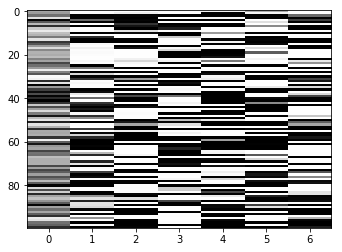

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(np.array(e_out.transpose() * 127 + 128,dtype=np.int32),
           cmap='gray',
           aspect=0.05)

## 모델 저장

In [68]:
saver = tf.train.Saver()
saver.save(tf.get_default_session(), 'logdir2/encoder_decoder/save')

'logdir2/encoder_decoder/save'

In [69]:
!ls -l logdir2/encoder_decoder

total 1722
-rwxrwxrwx 1 rhee users      65 Oct 11 10:55 checkpoint
-rwxrwxrwx 1 rhee users  893811 Oct 11 10:54 events.out.tfevents.1507686474.rhee
-rwxrwxrwx 1 rhee users 1254164 Oct 11 10:55 save.data-00000-of-00001
-rwxrwxrwx 1 rhee users    1677 Oct 11 10:55 save.index
-rwxrwxrwx 1 rhee users  505854 Oct 11 10:55 save.meta


In [70]:
# saver = tf.train.Saver()
# saver.restore(sess,tf.train.latest_checkpoint('logdir/rnn1'))